### Week 5: Digital Humanities 

In [43]:
import pandas as pd
import numpy as np; np.random.seed(1)  # fix a seed for reproducible random sampling
import matplotlib.pyplot as plt
import scipy.special
import itertools
import re
from scipy.stats import binom
from collections import Counter


In [44]:
words_of_interest = ['upon', 'the', 'state', 'enough', 'while', 'any', 'his', 'were','to']
df = pd.read_csv('data/federalist-papersNew2.csv', index_col=0)
print(len(df))
df[words_of_interest].sample(6)


85


,upon,the,state,enough,while,any,his,were,to
39,0,300,12,0,0,4,1,6,91
45,0,278,18,0,0,4,1,6,66
28,3,166,13,0,0,2,0,2,66
41,0,336,3,0,0,6,3,6,119
37,1,230,5,0,0,3,5,3,85
81,13,389,26,0,2,15,0,3,163


In [45]:

disputed_essays = df[df['AUTHOR'] == 'Hamilton OR Madison'].index
assert len(disputed_essays) == 12  # there are twelve disputed essays
# numbers widely used to identify the essays
assert set(disputed_essays) == {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63}

In [46]:
df_known = df.loc[df['AUTHOR'].isin(('Hamilton', 'Madison'))]
print(df_known['AUTHOR'].value_counts())

Hamilton    51
Madison     14
Name: AUTHOR, dtype: int64


In [47]:
# df_known.groupby('AUTHOR')['upon'].head()
# df_known.groupby('AUTHOR')['upon'].tail()
df_known.groupby('AUTHOR')['upon'].sum()

AUTHOR
Hamilton    374
Madison       7
Name: upon, dtype: int64

#### Q1. Considering the words ‘to’, ‘upon’ and ‘would’, draw a graph representing the occurrences of those words in Hamilton and Madison’s articles.

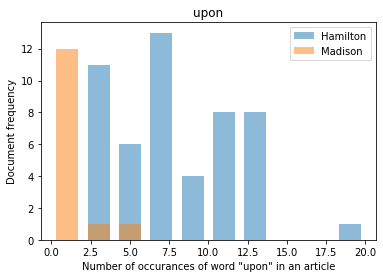

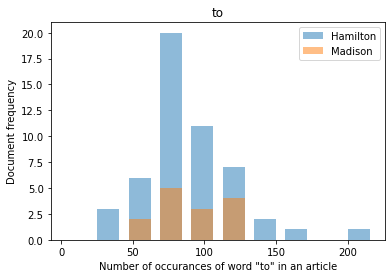

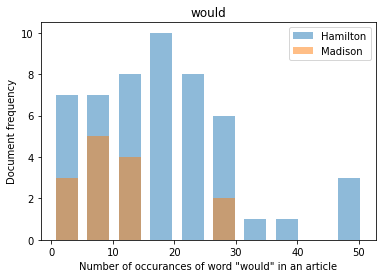

In [48]:
for word in ['upon','to','would']:
    
    maxwordcount = df_known[word].max()
    df_known.groupby('AUTHOR')[word].plot.hist(rwidth=0.7,alpha=0.5, range=(0, maxwordcount), legend=True)
    plt.title(word)
    plt.xlabel('Number of occurances of word "{}" in an article'.format(word))
    plt.ylabel('Document frequency')

    plt.show()


#### Q2. With these three words, model them as a binomial to reflect either occurrences in Hamilton or Madison’s writing style.

#### Binomial distribution for 3 words for Hamilton papers

374 0.36666666666666664 7.333333333333333


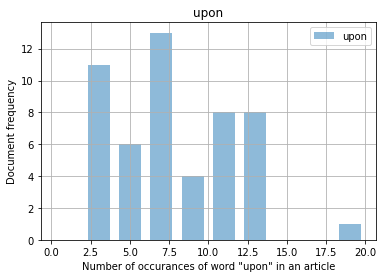

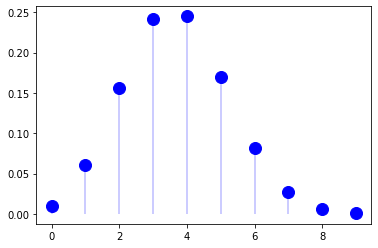

4584 0.41042170292774643 89.88235294117646


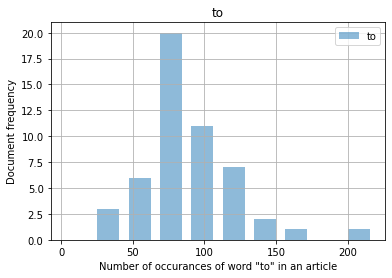

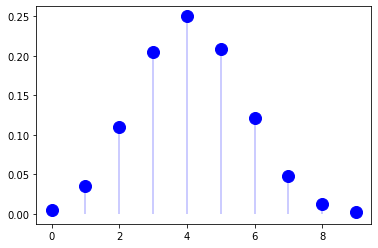

929 0.3571703191080354 18.215686274509803


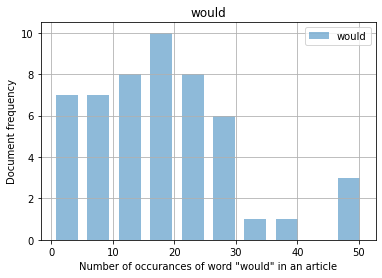

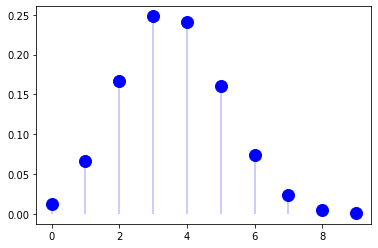

In [49]:
for word in ['upon','to', 'would']:
    
    maxwordcount = df_known[word].max()
    df_known[df_known['AUTHOR'] == 'Hamilton'][word].hist(rwidth=0.7,alpha=0.5, range=(0, maxwordcount), bins=10, legend=True)
    plt.title(word)
    plt.xlabel('Number of occurances of word "{}" in an article'.format(word))
    plt.ylabel('Document frequency')

    total = df[df['AUTHOR'] == 'Hamilton'][word].sum()
    mean = df[df['AUTHOR'] == 'Hamilton'][word].mean()
    p = mean/ maxwordcount
    print(total,p, mean) 

    fig, ax = plt.subplots()    
    n = 10
    x = np.arange(0, 10)
    ax.plot(x, binom.pmf(x, n, p), 'bo', ms=12, label='binom pmf')
    ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=2, alpha=0.2)

    plt.show()

#### Binomial distribution for 3 words for Madison papers

7 0.025 0.5


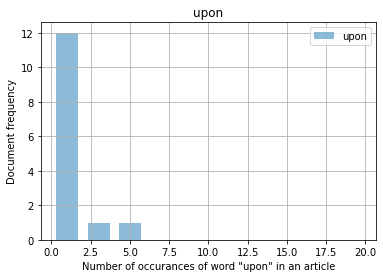

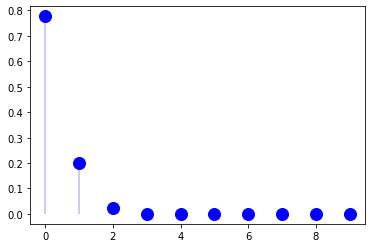

1261 0.4112850619699935 90.07142857142857


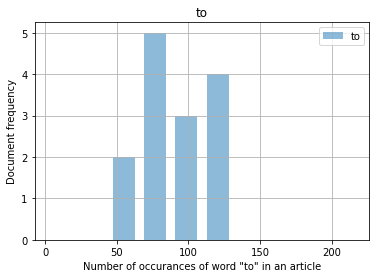

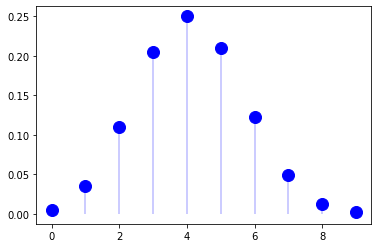

159 0.22268907563025211 11.357142857142858


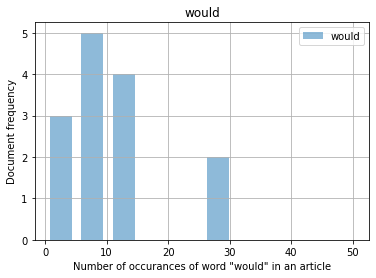

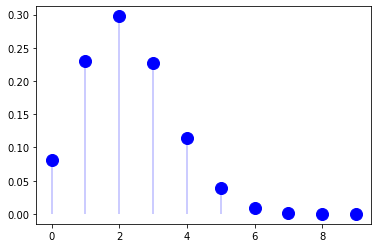

In [50]:
for word in ['upon','to', 'would']:
    
    maxwordcount = df_known[word].max()
    df_known[df_known['AUTHOR'] == 'Madison'][word].hist(rwidth=0.7,alpha=0.5, range=(0, maxwordcount), bins=10, legend=True)
    plt.title(word)
    plt.xlabel('Number of occurances of word "{}" in an article'.format(word))
    plt.ylabel('Document frequency')

    total = df[df['AUTHOR'] == 'Madison'][word].sum()
    mean = df[df['AUTHOR'] == 'Madison'][word].mean()
    p = mean/ maxwordcount
    print(total,p, mean) 

    fig, ax = plt.subplots()    
    n = 10
    x = np.arange(0, 10)
    ax.plot(x, binom.pmf(x, n, p), 'bo', ms=12, label='binom pmf')
    ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=2, alpha=0.2)

    plt.show()

#### Q3. Represent with a histogram the article length. Does it make sense to view this distribution as a Gaussian?

Yes, as below plotted graph we can view the artical length distribution as a Gaussian

In [51]:
print("Original Cols length: {}".format(len(df.columns)))

all_word_cols = []
for col in df.columns:
    k= re.findall('[a-z]+', col,re.I)
    if k != []:
        all_word_cols.append(col)
print("Processed word tokens length: {}".format(len(all_word_cols)))

Original Cols length: 11501
Processed word tokens length: 11275


(85, 11275)
1     1620
2     1673
3     1449
4     1645
5     1347
      ... 
81    3924
82    1549
83    5848
84    4191
85    2714
Length: 85, dtype: int64


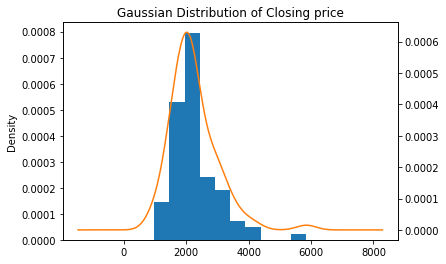

In [52]:
edited_rows = df[all_word_cols]
print(edited_rows.shape)
#edited_rows.head()
count_of_tokens = edited_rows.sum(axis=1)
print(count_of_tokens)
count_of_tokens.plot(x= df, kind ='hist', density=True)

count_of_tokens.plot(kind='kde', secondary_y=True)

plt.title("Gaussian Distribution of Closing price")
plt.show()

### Problem 2: Processing the text

In [97]:
# Loading sms_spam.csv file
sms_text = pd.read_csv('corpus/sms_spam.csv', delimiter=",")
sms_text.head(5)

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


#### Q1. Transform the text to lowercase

In [98]:
sms_text_lower = sms_text.copy()
sms_text_lower['text'] = sms_text_lower['text'].str.lower()
print("Length of tokens in sms_text['text'] : {}".format(len(sms_text_lower['text'])))
print(sms_text_lower.head(20))

Length of tokens in sms_text['text'] : 5559
    type                                               text
0    ham  hope you are having a good week. just checking in
1    ham                            k..give back my thanks.
2    ham        am also doing in cbe only. but have to pay.
3   spam  complimentary 4 star ibiza holiday or £10,000 ...
4   spam  okmail: dear dave this is your final notice to...
5    ham  aiya we discuss later lar... pick u up at 4 is...
6    ham                             are you this much buzy
7    ham                    please ask mummy to call father
8   spam  marvel mobile play the official ultimate spide...
9    ham     fyi i'm at usf now, swing by the room whenever
10   ham  sure thing big man. i have hockey elections at...
11   ham                                  i anything lor...
12   ham  by march ending, i should be ready. but will c...
13   ham                             hmm well, night night 
14   ham  k i'll be sure to get up before noon and see w

#### Q2. Normalize the tokens (replace the English contraction by their equivalent such ‘can’t’ -> ‘can not’)

In [109]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
# contractions_array = []
# for i, s in enumerate(sms_text['text']):
#     token_without_not = [word for word in s.split(" ") if word in contractions]
#     #print(token_without_not)
    
#     for item in token_without_not:
#         replace_item = item.replace(item,contractions[item])
#         contractions_array.append(replace_item)
#     #print(contractions_array)
#     sms_text['text'][i] = contractions_array
# print("Length of tokens in sms_text['text'] : {}".format(len(sms_text['text'])))
#sms_text.head(20)


#### Q3. Be able to read a list of stopwords and to remove them when they appear in the text (two such lists are given in the folder ‘Corpus’).

In [110]:
# Removing special characters from a file
stop_words_1 = np.loadtxt('corpus/stopwords.txt', dtype='str')
sms_text1 = sms_text_lower.copy()

for i,s in enumerate(sms_text1['text']):
    only_words = re.findall("[\w]+", s)
    sms_text1['text'][i] = only_words 
    #print(only_words)

print(sms_text1)

      type                                               text
0      ham  [hope, you, are, having, a, good, week, just, ...
1      ham                        [k, give, back, my, thanks]
2      ham  [am, also, doing, in, cbe, only, but, have, to...
3     spam  [complimentary, 4, star, ibiza, holiday, or, 1...
4     spam  [okmail, dear, dave, this, is, your, final, no...
...    ...                                                ...
5554   ham  [you, are, a, great, role, model, you, are, gi...
5555   ham  [awesome, i, remember, the, last, time, we, go...
5556  spam  [if, you, don, t, your, prize, will, go, to, a...
5557  spam  [sms, ac, jsco, energy, is, high, but, u, may,...
5558   ham             [shall, call, now, dear, having, food]

[5559 rows x 2 columns]


In [111]:
for index,sms in enumerate(sms_text1['text']):
    token_without_sw = [word for word in sms.split(" ") if not word in stop_words_1]
    sms = (" ").join(token_without_sw)
    sms_text1['text'][index] = sms 
sms_text1.head(5)


AttributeError: 'list' object has no attribute 'split'

In [106]:
stop_words_2 = np.loadtxt('corpus/StopwordSMART.txt', dtype='str')
#print(stop_words_2)

sms_text2 = sms_text1.copy()

for index,sms in enumerate(sms_text2['text']):
    token_without_sw = [word for word in sms.split(" ") if not word in stop_words_2]
    sms = (" ").join(token_without_sw)
    sms_text2['text'][index] = sms 
print(sms_text2.head(5))

AttributeError: 'list' object has no attribute 'split'

#### Q4. Apply your preprocessing to both the spam and ham SMSs. Return the top 20 most frequent word-types for both categories

In [93]:
ham_tokens = sms_text2.loc[sms_text2['type'] == 'ham']
print("Total hams: ",len(ham_tokens))
print(ham_tokens['text'].head(5))
spam_tokens = sms_text2.loc[sms_text2['type'] == 'spam']
print("Total Spams:",len(spam_tokens))

Total hams:  4812
0                              type
1                          typetext
2                    cbe only. pay.
5    aiya discuss lar... pick 4 it?
6                              buzy
Name: text, dtype: object
Total Spams: 747


#### 20 most frequent word-types for "ham" categories

In [94]:
 
words_all = []

for i, words in enumerate(ham_tokens['text']):
    total_words = words.split(" ")
    for w in total_words: 
        words_all.append(w)
        
words_dict = Counter(words_all)
dict_sorted = {k: v for k, v in sorted(words_dict.items(), key=lambda item: item[1], reverse=True)}
print(list(dict_sorted.keys())[:20])


        

['', '2', '#', 'ur', '.', 'call', 'good', '?', '...', '4', 'time', 'love', 'dont', 'send', 'home', 'day', 'back', 'hope', '&', 'happy']


#### 20 most frequent word-types for "spam" categories

In [79]:
words_all_spam = []

for i, words_spam in enumerate(spam_tokens['text']):
    total_words = words_spam.split(" ")
    for w in total_words: 
        words_all_spam.append(w)
        
words_dict = Counter(words_all_spam)
dict_sorted = {k: v for k, v in sorted(words_dict.items(), key=lambda item: item[1], reverse=True)}
print(list(dict_sorted.keys())[:20])

['call', 'free', '2', 'ur', 'txt', 'text', 'mobile', 'claim', 'reply', '&', '4', 'stop', 'now!', 'send', 'nokia', 'win', 'prize', 'cash', 'contact', '-']
